# Read and analyze MCMC chain

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import h5py

from emcee.autocorr import integrated_time
from eryn.backends import HDFBackend

Load the file

In [2]:
filename = "whittle_gaps.h5"
f = h5py.File(filename, 'r')

emri_chain_complete = f['mcmc/chain/emri'][:]
#emri_chain = emri_chain_complete[:981, :, :, :, :]
emri_chain = emri_chain_complete[:, :, :, :, :]
f.close()

In [3]:
print(f"Samples shape: {emri_chain.shape}")

nsteps, ntemps, nwalkers, nbranches, ndims = emri_chain.shape

Samples shape: (1000, 10, 32, 1, 13)


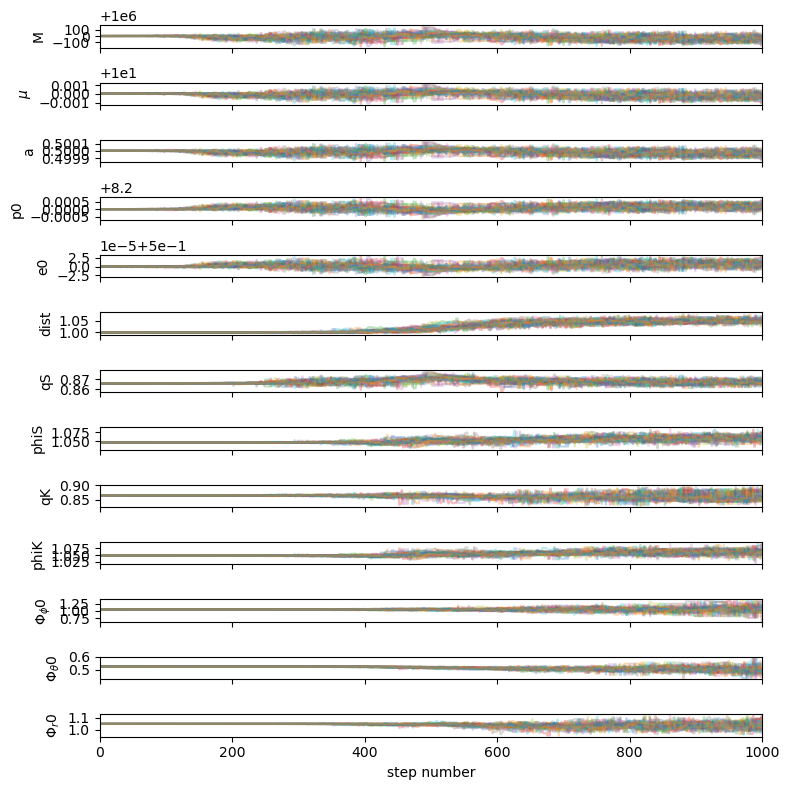

In [4]:
fig, axes = plt.subplots(ndims, figsize=(8, 8), sharex=True)
labels = ["M",r"$\mu$", 'a', 'p0', 'e0', 'dist', 'qS', 'phiS', 'qK', 'phiK', r'$\Phi_{\phi}0$', r'$\Phi_{\theta}0$', r'$\Phi_r0$',]

for i in range(ndims):
    ax = axes[i]
    ax.set_ylabel(labels[i])
    ax.set_xlim(0, len(emri_chain))
    
    # Plot each walker
    for walk in range(nwalkers):
        ax.plot(emri_chain[:, 0, walk, 0, i], alpha=0.3)
        
axes[-1].set_xlabel("step number")
plt.tight_layout()
plt.show()

Thinned and burned-in chain

In [5]:
tau = integrated_time(emri_chain[:, 0, :, 0, :], quiet=True) 
print('Autocorrelation time: '+str(tau))

The chain is shorter than 50 times the integrated autocorrelation time for 12 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 38.72463903  37.10380484  37.56041813  38.56387278  40.74461379
 132.27543566  62.38411932 112.44791966  35.85803113 113.4718237
   7.96084937 110.34107561  67.16107568]


Autocorrelation time: [ 38.72463903  37.10380484  37.56041813  38.56387278  40.74461379
 132.27543566  62.38411932 112.44791966  35.85803113 113.4718237
   7.96084937 110.34107561  67.16107568]


In [6]:
thin = int(0.5*np.floor(np.min(tau)))
#thin = int(np.ceil(np.max(tau)))
#thin = 50
burnin = 2*int(np.ceil(np.max(tau)))
#burnin = 4 * thin
samples = emri_chain[burnin:, 0, :, 0, :]  # [steps after burnin, temp=0, all walkers, branch dim=0, parameters]

print("Original nsteps:", emri_chain.shape[0])
print("Burned-in  nsteps:", samples.shape[0])

Original nsteps: 1000
Burned-in  nsteps: 734


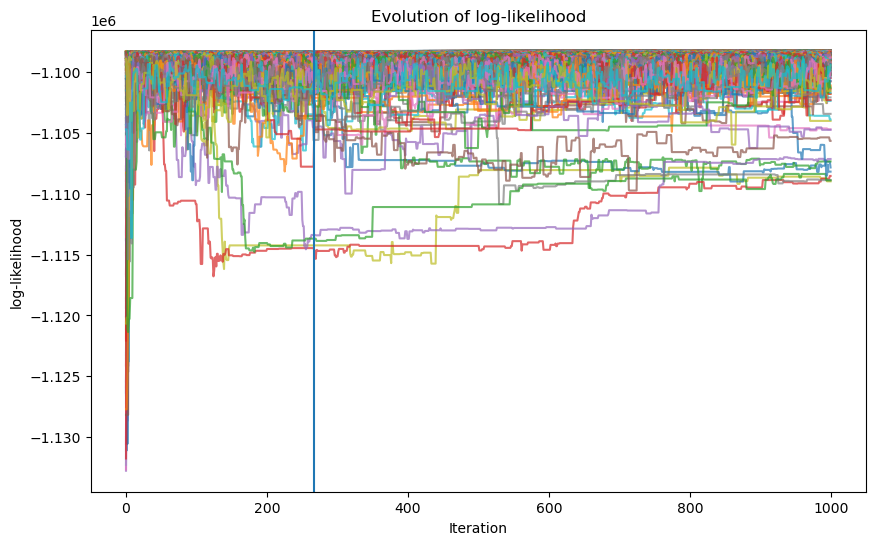

In [7]:
backend = HDFBackend(filename, read_only=True)

ll = backend.get_log_like()

# plot
plt.figure(figsize=(10,6))
for i in range(min(10, ll.shape[1])):  # max 10 walker
    plt.plot(ll[:, i], alpha=0.7)

plt.axvline(burnin)

plt.xlabel("Iteration")
plt.ylabel("log-likelihood")
plt.title("Evolution of log-likelihood")
plt.show()

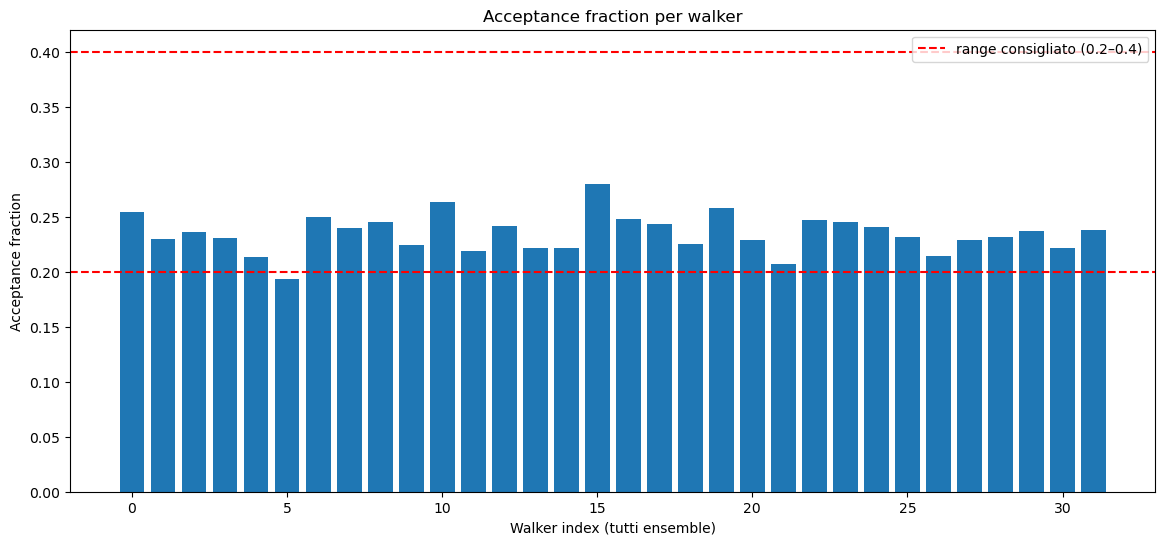

In [8]:
n_iter = backend.iteration

acc = backend.accepted[0,:]  # shape (n_temp, n_walkers)

acc_fraction = (acc / n_iter).flatten()   # shape (n_ensembles * n_walkers,)

plt.figure(figsize=(14,6))
plt.bar(np.arange(len(acc_fraction)), acc_fraction, width=0.8)
plt.axhline(0.2, color="r", ls="--", label="range consigliato (0.2–0.4)")
plt.axhline(0.4, color="r", ls="--")
plt.xlabel("Walker index (tutti ensemble)")
plt.ylabel("Acceptance fraction")
plt.title("Acceptance fraction per walker")
plt.legend()
plt.show()

In [9]:
chain = backend.get_chain()
print("Catena shape:", np.shape(chain))  # (n_iter, n_walkers, n_dim)

Catena shape: ()


In [10]:
thin_samples = samples[::thin, :, :]

print("Burned-in  nsteps:", samples.shape[0])
print("Burned-in and thinned  nsteps:", thin_samples.shape[0])

Burned-in  nsteps: 734
Burned-in and thinned  nsteps: 245


Flat chain

In [11]:
flat_samples = thin_samples.reshape(-1, ndims)  # Combine steps and walkers dimensions
print(f"Flattened samples shape: {flat_samples.shape}")

Flattened samples shape: (7840, 13)


Visualize the data

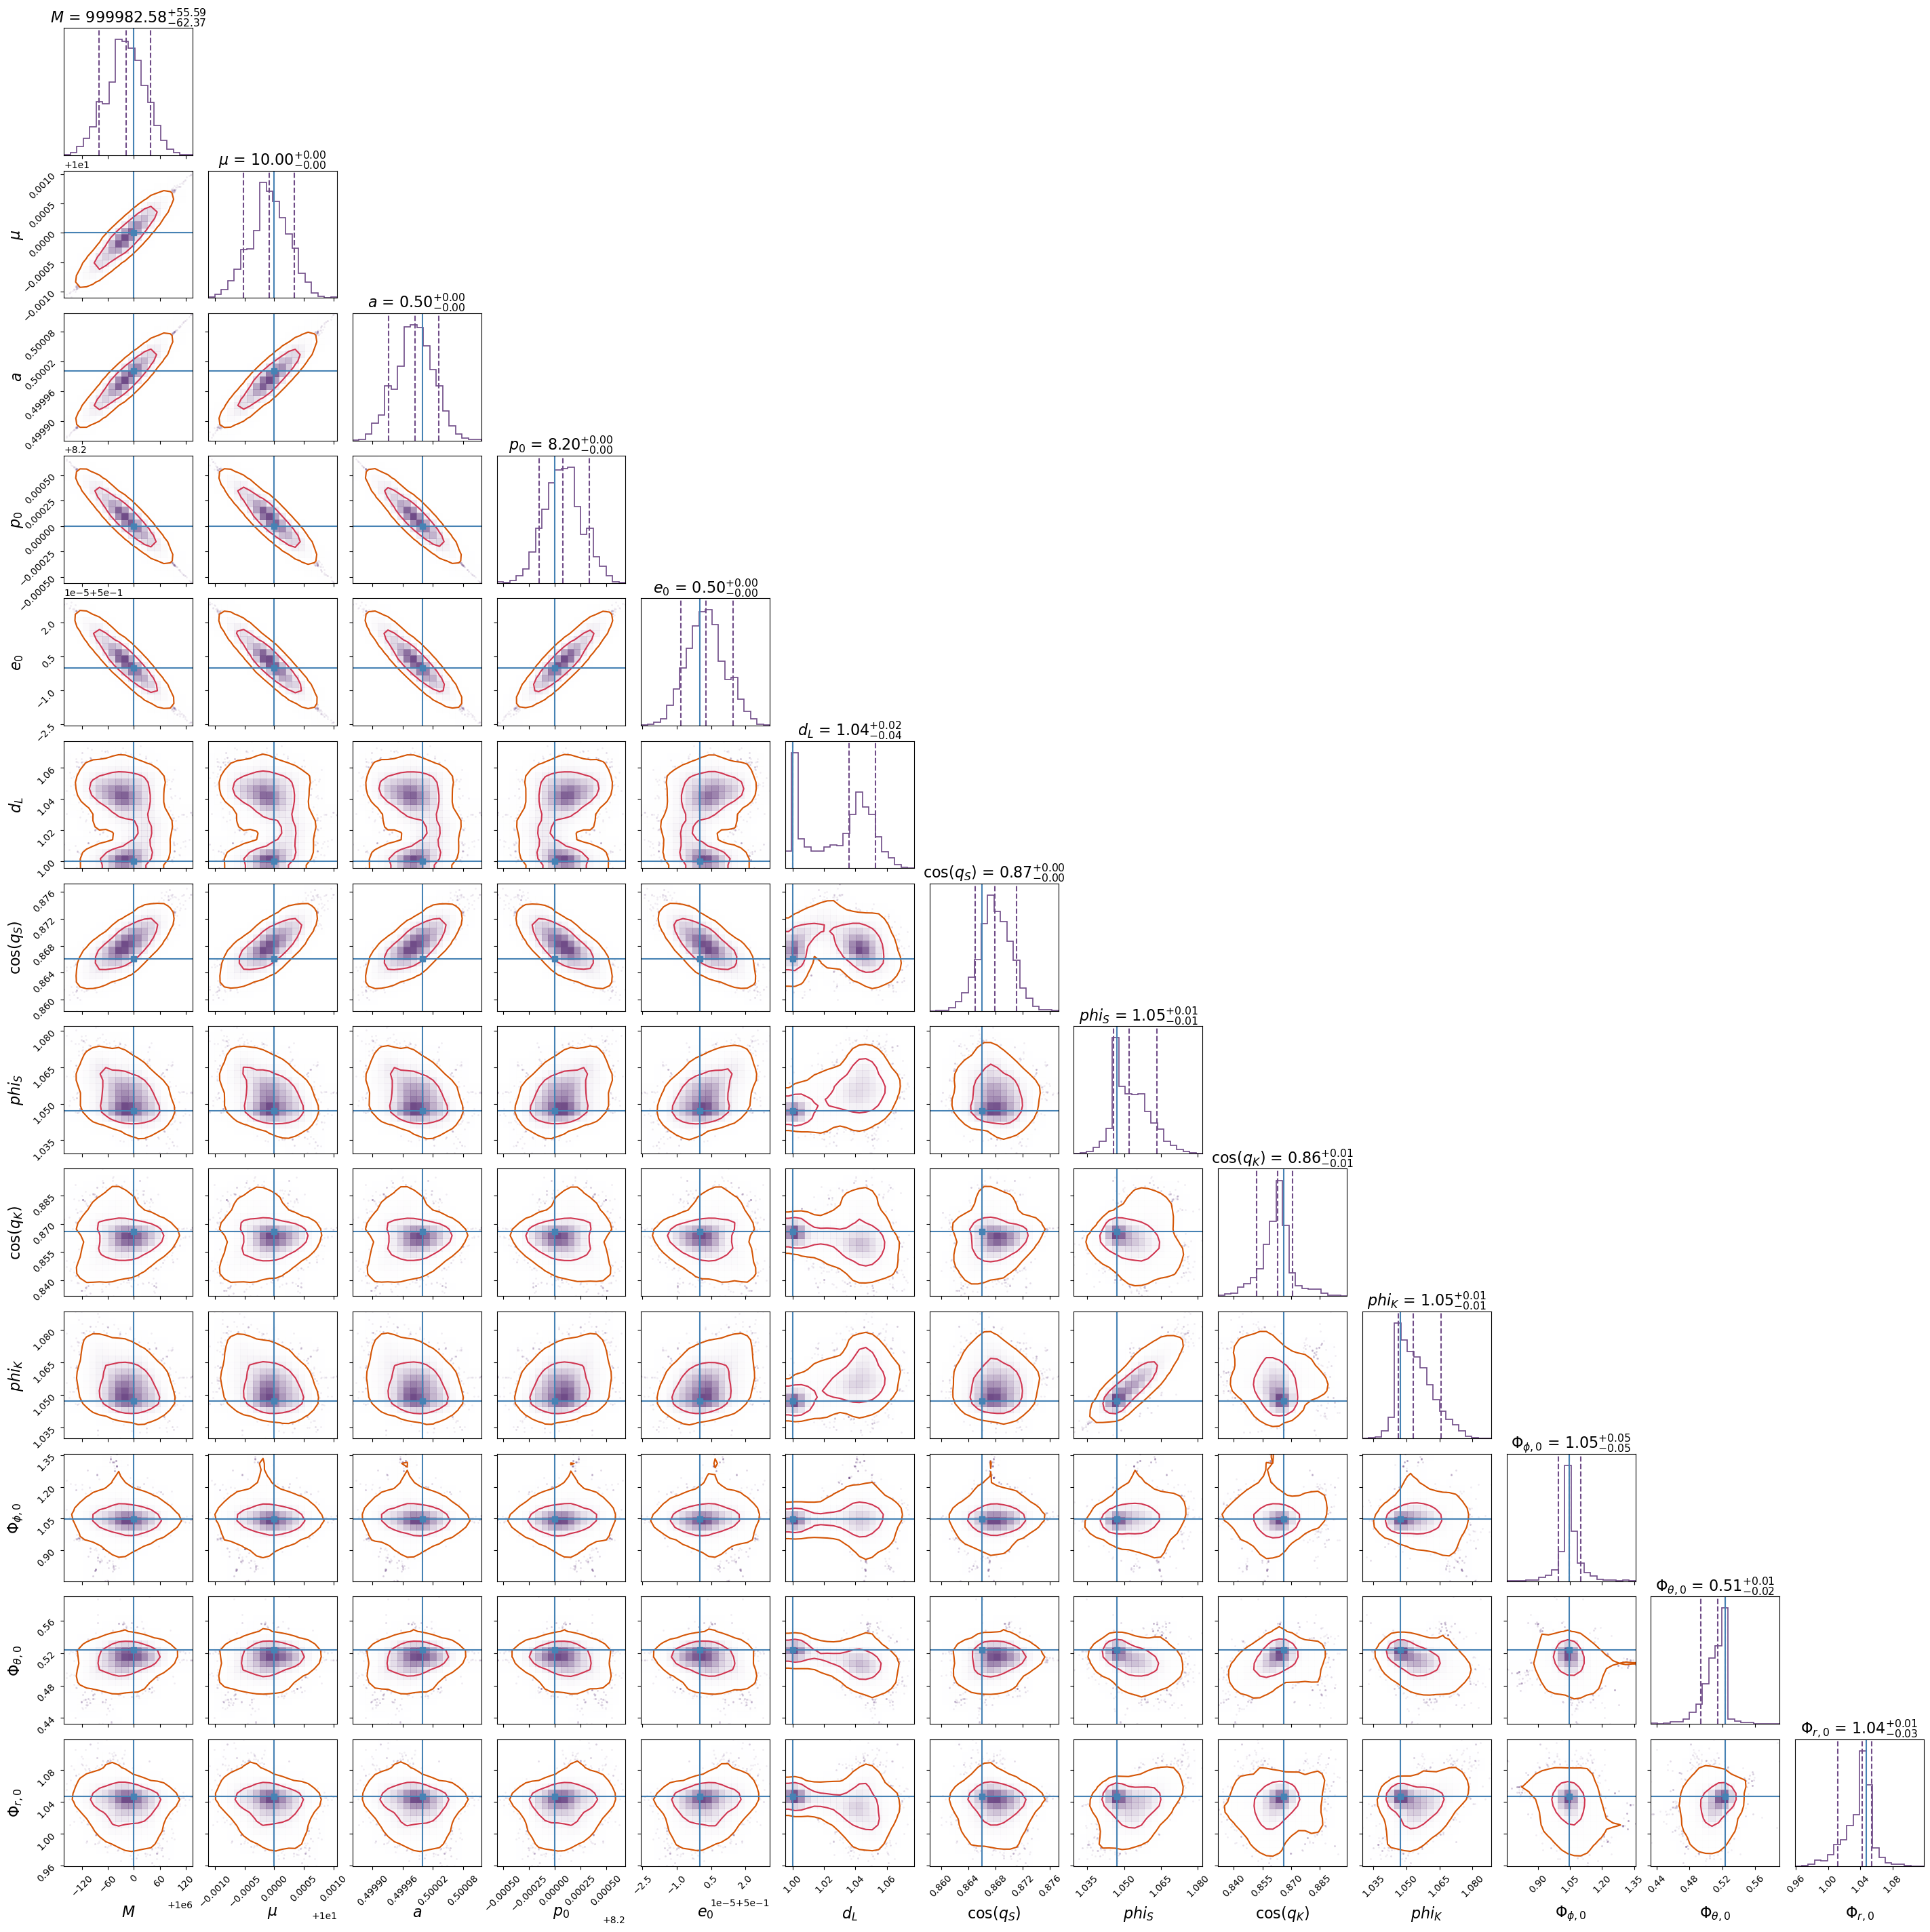

In [12]:
labels = [r'$M$', r'$\mu$', r'$a$', r'$p_0$', r'$e_0$', r'$d_L$', r'$\cos(q_S)$', r'$phi_S$', r'$\cos(q_K)$', r'$phi_K$', r'$\Phi_{\phi,0}$', r'$\Phi_{\theta,0}$', r'$\Phi_{r,0}$',]
true_param = [1e6, 10, 0.5, 8.2, 0.5, 1.0, np.cos(np.pi / 6), np.pi / 3, np.cos(np.pi / 6), np.pi / 3, np.pi / 3, np.pi / 6, np.pi / 3]

fig = corner.corner(flat_samples, labels=labels, truths=true_param, levels=[0.68, 0.95],
                    quantiles=[0.10, 0.5, 0.90], show_titles=True, title_fmt=".2f",
                    plot_density=True, smooth=1, color='#704C88',
                    hist_kwargs={'alpha': 1, 'edgecolor': '#704C88', 'linewidth': 1.2,},
                    contour_kwargs={'colors': ['#d45404', '#D03550' ], 'linewidths': 1.5,},
                    title_kwargs={'fontsize': 16 },
                    label_kwargs={"fontsize": 16, "labelpad": 8}
)
'''
fig = corner.corner(flat_samples, labels=labels, truths=true_param, levels=[0.68, 0.95],
                    quantiles=[0.10, 0.5, 0.90], show_titles=True, title_fmt=".2f",
                    plot_density=True, smooth=1, color='rebeccapurple',
                    hist_kwargs={'alpha': 0.8, 'edgecolor': 'rebeccapurple', 'linewidth': 1.2,},
                    contour_kwargs={'colors': ['tomato', 'orangered' ], 'linewidths': 1.5,},
                    title_kwargs={'fontsize': 16 },
                    label_kwargs={"fontsize": 16, "labelpad": 8}
)
'''
plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0.12)
plt.savefig("noise_cornerplot.pdf",
            dpi=300,
            bbox_inches="tight")
plt.show()

Median and percentiles

In [13]:
def fmt(x):
    return f"{x:.3g}"  # 3 cifre significative

# larghezza della colonna label
w_label = max(len(l) for l in labels) + 2

for label, col in zip(labels, flat_samples.T):
    low, med, up = np.percentile(col, [5, 50, 95])
    err_low, err_up = med - low, up - med

    print(
        f"{label:<{w_label}}"
        f"{fmt(med):>8}   "
        f"+{fmt(err_up):<6} "
        f"-{fmt(err_low):<6}"
    )

$M$                   1e+06   +70.1   -75.9  
$\mu$                    10   +0.000519 -0.000559
$a$                     0.5   +5.94e-05 -6.45e-05
$p_0$                   8.2   +0.000316 -0.000289
$e_0$                   0.5   +1.48e-05 -1.33e-05
$d_L$                  1.04   +0.0213 -0.0359
$\cos(q_S)$           0.868   +0.00404 -0.00382
$phi_S$                1.05   +0.0143 -0.00841
$\cos(q_K)$           0.863   +0.0138 -0.0153
$phi_K$                1.05   +0.0169 -0.00857
$\Phi_{\phi,0}$        1.05   +0.0895 -0.0841
$\Phi_{\theta,0}$     0.514   +0.00992 -0.028 
$\Phi_{r,0}$           1.04   +0.0189 -0.0392


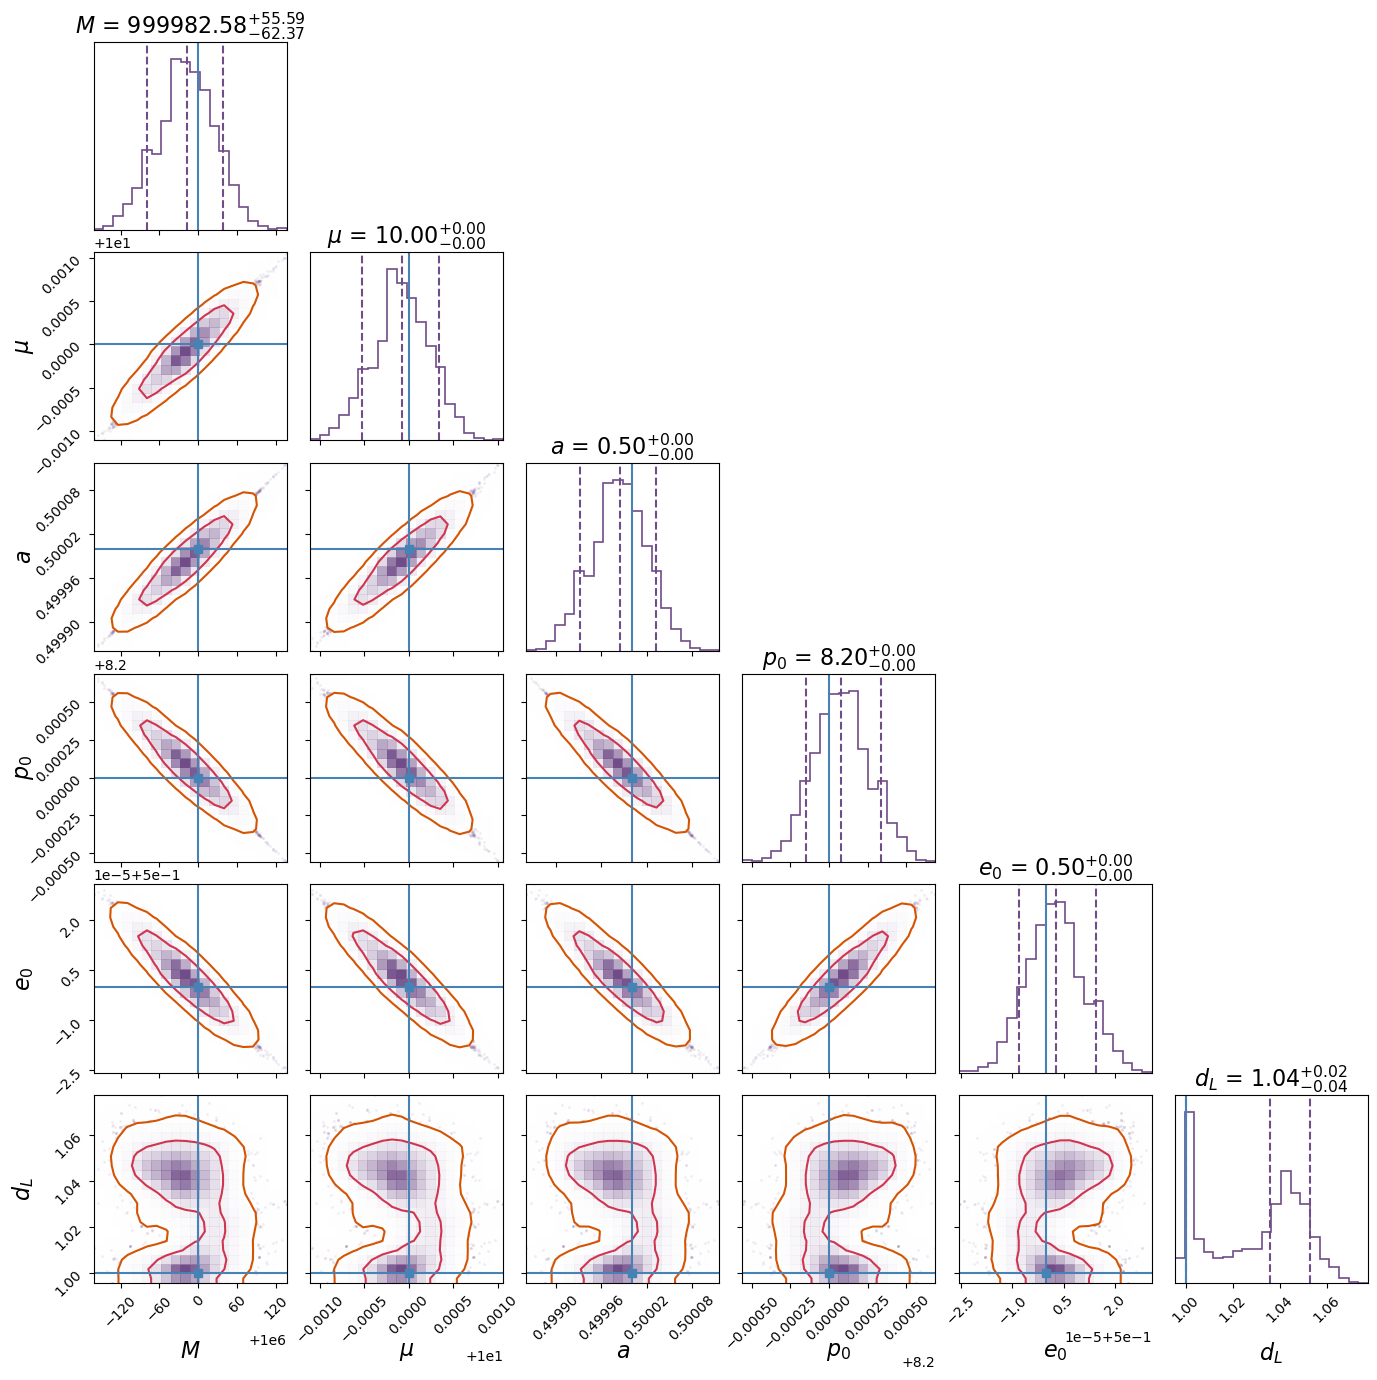

In [14]:
labels = [r'$M$', r'$\mu$', r'$a$', r'$p_0$', r'$e_0$', r'$d_L$', r'$\cos(q_S)$', r'$phi_S$', r'$\cos(q_K)$', r'$phi_K$', r'$\Phi_{\phi,0}$', r'$\Phi_{\theta,0}$', r'$\Phi_{r,0}$',]
true_param = [1e6, 10, 0.5, 8.2, 0.5, 1.0, np.cos(np.pi / 6), np.pi / 3, np.cos(np.pi / 6), np.pi / 3, np.pi / 3, np.pi / 6, np.pi / 3]

fig = corner.corner(flat_samples[:,:6], labels=labels[:6], truths=true_param[:6], levels=[0.68, 0.95],
                    quantiles=[0.10, 0.5, 0.90], show_titles=True, #title_fmt=".2",
                    plot_density=True, smooth=1, color='#704C88',
                    max_n_ticks=5,  # Massimo 3 tick per asse
                    hist_kwargs={'alpha': 1, 'edgecolor': '#704C88', 'linewidth': 1.2,},
                    contour_kwargs={'colors': ['#d45404', '#D03550' ], 'linewidths': 1.5,},
                    title_kwargs={'fontsize': 16 },
                    label_kwargs={"fontsize": 16, "labelpad": 8}
)



#fig.set_size_inches(10, 10)

plt.tight_layout()
plt.subplots_adjust(wspace=0.12, hspace=0.12)
plt.savefig("noise_cornerplot_red.pdf",
            dpi=300,
            bbox_inches="tight")
plt.show()